In [1]:
import nannyml as nml
import pandas as pd
import numpy as np
from IPython.display import display
from IPython.display import Image
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
import sys
import scipy.stats as stats
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

# Carga de dataframe de referencia y analisis

In [2]:
analysis = pd.read_csv('pack_datos_analisis.csv')
reference = pd.read_csv('pack_datos_referencia.csv')
analysis = analysis.drop(['Unnamed: 0'], axis=1)
reference = reference.drop(['Unnamed: 0'], axis=1)




analysis = analysis.drop(['Hijos'], axis=1)
reference = reference.drop(['Nivel de estudios'], axis=1)
reference = reference.drop(['Hijos'], axis=1)
analysis = analysis.drop(['Nivel de estudios'], axis=1)

# Rellenar información sobre el dataframe
En cada casilla de la lista, rellena con un
1 -> Si la variable es numerica/cuantitativa/continua
2 -> Si la variable es 
categorica o binaria.
Escoge el número de datahunks en los que deseas partir tu dataframe de analisis

In [3]:
lista_tipos_de_datos = [1,1]
ndc = 2
n_observaciones_dc = len(analysis)/ndc
n_observaciones_dc = int(n_observaciones_dc)
print('EL número de observaciones por datachunk será de',n_observaciones_dc)

EL número de observaciones por datachunk será de 2500


# Aqui acaba ya la interacción, todo esto ya es automatico

In [4]:
var_num = 0
var_cat = 0
metadata_flag = 0
case_flag = 0

for i in range(len(lista_tipos_de_datos)):
    if lista_tipos_de_datos[i] == 1:
        var_num = var_num +1
    if lista_tipos_de_datos[i] == 2:
        var_cat = var_cat +1
        
    
if var_cat > 0: 
    print("Se usará K-S para la detección univariante, Chi square para categoricas y PCA error para la multivariante")
    metadata_flag = 1
    case_flag = 1
    
    
elif var_cat == 0 : 
    print("Se usará K-S para la detección univariante y WW para a multivariante")
    case_flag = 2

        


Se usará K-S para la detección univariante y WW para a multivariante


In [5]:
if metadata_flag == 1: 

    #Columna de timestamp
    time_str_ref = '23/2/2000 11:12:22.234513'
    date_format_str = '%d/%m/%Y %H:%M:%S.%f'
    fecha_a_aumentar_reference = datetime.strptime(time_str_ref, date_format_str)
    lista_fechas_ref = []
    
    for i in range (len(reference)):
        fecha_a_aumentar_reference  = fecha_a_aumentar_reference +timedelta(minutes=5)
        lista_fechas_ref.append(fecha_a_aumentar_reference)
    
    reference['timestamp'] = lista_fechas_ref
    reference['timestamp'] = reference['timestamp'].astype(object)
    
    time_str_anal = '23/2/2020 11:12:22.234513'
    date_format_str = '%d/%m/%Y %H:%M:%S.%f'
    fecha_a_aumentar_analysis = datetime.strptime(time_str_anal, date_format_str)
    lista_fechas_anal = []
    
    for i in range (len(analysis)):
        fecha_a_aumentar_analysis  = fecha_a_aumentar_analysis +timedelta(minutes=5)
        lista_fechas_anal.append(fecha_a_aumentar_analysis)
        
    analysis['timestamp'] = lista_fechas_anal
    analysis['timestamp'] = analysis['timestamp'].astype(object)
    
    #Columna de y_pred, y_pred_proba y actual
    analysis['y_pred_proba'] = np.zeros(len(analysis))
    reference['y_pred_proba'] = np.zeros(len(reference))
    analysis['y_pred'] = np.zeros(len(analysis))
    reference['y_pred'] = np.zeros(len(reference))
    reference['actual']= np.zeros(len(reference))
    analysis['partition'] = 'analysis'
    reference['partition'] = 'reference'

    

    

Defino algunas funciones:

In [6]:
def mst_edges(V, k):
    """
    Construct the approximate minimum spanning tree from vectors V
    :param: V: 2D array, sequence of vectors
    :param: k: int the number of neighbor to consider for each vector
    :return: V ndarray of edges forming the MST
    """

    # k = len(X)-1 gives the exact MST
    k = min(len(V) - 1, k)

    # generate a sparse graph using the k nearest neighbors of each point
    G = kneighbors_graph(V, n_neighbors=k, mode='distance')

    # Compute the minimum spanning tree of this graph
    full_tree = minimum_spanning_tree(G, overwrite=True)

    return np.array(full_tree.nonzero()).T

def ww_test(X, Y, k=10):
    """
    Multi-dimensional Wald-Wolfowitz test
    :param X: multivariate sample X as a numpy ndarray
    :param Y: multivariate sample Y as a numpy ndarray
    :param k: number of neighbors to consider for each vector
    :return: W the WW test statistic, R the number of runs
    """
    m, n = len(X), len(Y)
    N = m + n

    XY = np.concatenate([X, Y]).astype(float)

    # XY += np.random.normal(0, noise_scale, XY.shape)

    edges = mst_edges(XY, k)

    labels = np.array([0] * m + [1] * n)

    c = labels[edges]
    runs_edges = edges[c[:, 0] == c[:, 1]]

    # number of runs is the total number of observations minus edges within each run
    R = N - len(runs_edges)

    # expected value of R
    e_R = ((2.0 * m * n) / N) + 1

    # variance of R is _numer/_denom
    _numer = 2 * m * n * (2 * m * n - N)
    _denom = N ** 2 * (N - 1)

    # see Eq. 1 in Friedman 1979
    # W approaches a standard normal distribution
    W = (R - e_R) / np.sqrt(_numer/_denom)

    return W, R


In [7]:
SIGNIFICANCE = 0.05

In [8]:
def multivariante_ww(ref,anal):
    #X = ref.to_numpy()
    
    
    valores_ww = np.zeros(ndc)
    
    for i in range(ndc):
        #print(i)
        Y = anal.iloc[n_observaciones_dc*i:n_observaciones_dc*(i+1),:].to_numpy()
        X = ref.iloc[n_observaciones_dc*i:n_observaciones_dc*(i+1),:].to_numpy()
        #print(Y)
        #print('-------------------------')
        if __name__ == '__main__':
            if len(sys.argv) != 3:
                print('Usage: $ python runs_test.py [X] [Y]')
                sys.exit(1)

        W, R = ww_test(X, Y)
        valores_ww[i] = stats.norm.cdf(W)  # one sided test
        
    
    return valores_ww


In [9]:
if metadata_flag == 1 and case_flag == 1:
    #----------------- UNIVARIANTE ----------------------
    metadata = nml.extract_metadata(data = reference, model_name='wfh_predictor', model_type='classification_binary')
    metadata.target_column_name = 'actual'


    univariate_calculator = nml.UnivariateStatisticalDriftCalculator(model_metadata=metadata, chunk_size=n_observaciones_dc)
    univariate_calculator = univariate_calculator.fit(reference_data=reference)

    data = pd.concat([reference, analysis], ignore_index=True)
    univariate_results = univariate_calculator.calculate(data=data)
    
    info_dd = pd.DataFrame()
    info_dd =univariate_results.data
    
    # ----------PCA error reconstraction-------------
    
    rcerror_calculator = nml.DataReconstructionDriftCalculator(model_metadata=metadata, chunk_size=n_observaciones_dc)
    rcerror_calculator = rcerror_calculator.fit(reference_data=reference)
    # let's see RC error statistics for all available data
    data = pd.concat([reference, analysis], ignore_index=True)
    rcerror_results = rcerror_calculator.calculate(data=data)

    
    from sklearn.impute import SimpleImputer
    # Let's initialize the object that will perform Data Reconstruction with PCA
    rcerror_calculator = nml.DataReconstructionDriftCalculator(
        model_metadata=metadata,
        chunk_size=n_observaciones_dc,
        imputer_categorical=SimpleImputer(strategy='constant', fill_value='missing'),
        imputer_continuous=SimpleImputer(strategy='median')
    )
    # NannyML compares drift versus the full reference dataset.
    rcerror_calculator.fit(reference_data=reference)
    # let's see RC error statistics for all available data
    rcerror_results = rcerror_calculator.calculate(data=data)
    
    info_dd_m = rcerror_results.data

    valores_er = info_dd_m["reconstruction_error"].to_numpy()
    upper_bound= info_dd_m["upper_threshold"].to_numpy()
    lower_bound = info_dd_m["lower_threshold"].to_numpy()




In [10]:
def ks(ref,anal,dd_univariate):
   
    p_value = 0.05
    j = 0
    if j ==0:
        dd_uni = dd_univariate
    
    for col in anal:
        
        valores_dd = np.zeros(ndc)
        #se ejecuta por cada columna
        
        
        for i in range(ndc):
            
            test = stats.ks_2samp(ref.iloc[:,j], anal.iloc[n_observaciones_dc*i:n_observaciones_dc*(i+1),j])

            valores_dd[i] = test[1]
            
            
        
        
        dd_uni.iloc[:,j] = valores_dd
        j = j+1
            
    
    
    return dd_uni

# Operaciones de todos los casos

In [11]:
# Estos pandas son auxiliares, mas adelante veré si se me son necesarios

dd_univariate = pd.DataFrame()
dd_multivariante = pd.DataFrame()
analisis = pd.DataFrame()
for col in analysis:
    dd_univariate[col]=np.zeros(ndc)
    
dd_multivariante_ww = np.zeros(ndc)

Caso 1

In [12]:
if case_flag ==1:
    #UNIVARIANTE
    
    pandas_aux = pd.DataFrame()
    for col in info_dd:
        string = col
        if '_p_value' in string:
            pandas_aux[col] = info_dd[col]


    
    for col in pandas_aux:
        string = col
        if 'y_pred_proba_p_value' in string:
            pandas_aux = pandas_aux.drop([col], axis=1)
    
    
    
    #MULTIVARIANTE
    pandas_m_aux = pd.DataFrame()
    

    for col in info_dd_m:
        string = col
        if 'reconstruction_error' in string:
            pandas_m_aux[col] = info_dd_m[col]

        if 'lower_threshold' in string:
            pandas_m_aux[col] = info_dd_m[col]

        if 'upper_threshold' in string:
            pandas_m_aux[col] = info_dd_m[col]
    analisis = pandas_aux
    auxaux = pd.DataFrame()
    auxaux['reconstruction_error'] = pandas_m_aux['reconstruction_error']
    analisis = pd.concat([analisis, auxaux],axis = 1)
    vector_up = pandas_m_aux['upper_threshold'].to_numpy()
    vector_down = pandas_m_aux['lower_threshold'].to_numpy()
    
    
    
   

Caso 2

In [13]:
if case_flag == 2:
    
    dd_univariate = ks(reference,analysis,dd_univariate)
    dd_multivariante_ww = multivariante_ww(reference,analysis)
    dd_multivariante['Multivariante'] = dd_multivariante_ww
    analisis = pd.concat([dd_univariate, dd_multivariante],axis = 1)


# REPRESENTACIÓN

Caso 1

In [14]:
if case_flag == 1:
    tamaño = 5*(len(lista_tipos_de_datos)+1)
    reduccion = len(analisis)
    reduccion =reduccion //2 
    
    fig, axs = plt.subplots(len(lista_tipos_de_datos)+1, 1)
    fig.set_figheight(tamaño)
    fig.set_figwidth(12)
    vector_p_valor = np.linspace(0.05,0.05,ndc)
    vector_up = np.linspace(vector_up[0],vector_up[0],ndc)
    vector_down = np.linspace(vector_down[0],vector_down[0],ndc)
    
    if len(analisis.iloc[reduccion:,:]) == len(vector_p_valor):
        analisis = analisis.iloc[reduccion:,:]
    else:
        analisis.iloc[reduccion+1:,:]
    

    i = 0
    x_points = np.linspace(1,ndc ,ndc )
    limite = len(analisis.columns) 
    flag = 0
    
    for col in analisis:

        if i != limite-1:
            axs[i].plot(x_points,analisis[col].to_numpy(),color=np.random.rand(3,), linewidth=2, linestyle="-",marker='s')
            axs[i].set_title(col)
            axs[i].plot(x_points,vector_p_valor,color="red", linewidth=1, linestyle="--")
        else:
            
            axs[i].plot(x_points,analisis[col].to_numpy(),color=np.random.rand(3,), linewidth=2, linestyle="-",marker='s')
            axs[i].set_title(col)
            axs[i].plot(x_points,vector_up,color="red", linewidth=1, linestyle="--")
            axs[i].plot(x_points,vector_down,color="red", linewidth=1, linestyle="--")
       
        i = i+1
        
    contador_alertas = np.zeros(len(analisis.columns))
    j = 0
    valor_max = vector_up[0]
    valor_min = vector_down[0]

    for col in analisis:

        auxiliar = analisis[col].to_numpy()
        if j != limite-1:


            for i in range(len(auxiliar)):

                if auxiliar[i] <0.05:

                    contador_alertas[j] = contador_alertas[j]+1
        else:

            for i in range(len(auxiliar)):

                if auxiliar[i]> valor_max or auxiliar[i]<valor_min:
                    contador_alertas[j] = contador_alertas[j]+1



        j = j+1

    plt.figure(figsize=(tamaño, 7))
    plt.suptitle('INFORME DE ALERTAS')

    fig = plt.bar(analisis.columns, contador_alertas)  

Caso 2

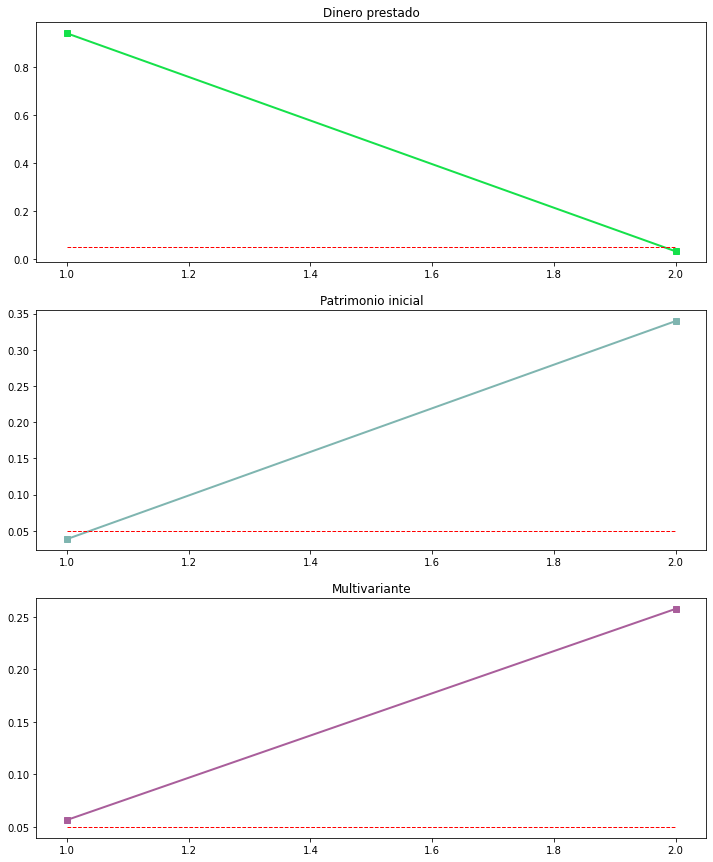

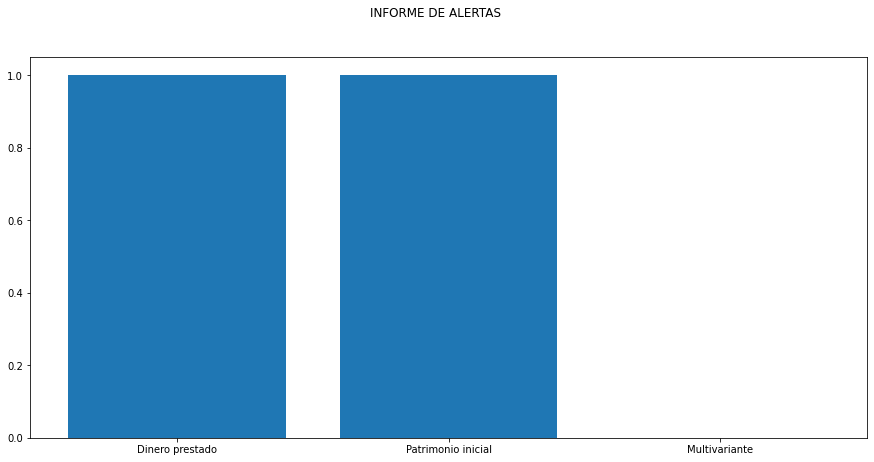

In [15]:
if case_flag == 2:
    tamaño = 5*(len(lista_tipos_de_datos)+1)
    
    fig, axs = plt.subplots(len(lista_tipos_de_datos)+1, 1)
    fig.set_figheight(tamaño)
    fig.set_figwidth(12)
    vector_p_valor = np.linspace(0.05,0.05,ndc)

    i = 0
    x_points = np.linspace(1,ndc ,ndc )
    limite = len(analisis.columns) 


    for col in analisis:
        axs[i].plot(x_points,analisis[col].to_numpy(),color=np.random.rand(3,), linewidth=2, linestyle="-",marker='s')
        axs[i].set_title(col)
        axs[i].plot(x_points,vector_p_valor,color="red", linewidth=1, linestyle="--")
        
        i = i+1
    
    contador_alertas = np.zeros(len(analisis.columns))
    j = 0


    for col in analisis:

        auxiliar = analisis[col].to_numpy()
        for i in range(len(auxiliar)):
            if auxiliar[i] <0.05:
                contador_alertas[j] = contador_alertas[j]+1



        j = j+1

    plt.figure(figsize=(tamaño, 7))
    plt.suptitle('INFORME DE ALERTAS')

    fig = plt.bar(analisis.columns, contador_alertas) 